#### Compute the excited state energy of H2O molecule using numpy and qEOM qiskit support

In [55]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper

from qiskit.algorithms.eigensolvers import NumPyEigensolver
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver
import numpy as np 
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer


In [56]:
driver = PySCFDriver(atom='O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0', unit=DistanceUnit.ANGSTROM, charge=0, spin=0, basis='sto3g')

es_problem = driver.run()
mapper = JordanWignerMapper()

#### Transform the problem to lower electrons and orbitals to quickly converge

In [57]:
active_space_transformer = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=3)
es_problem = active_space_transformer.transform(es_problem)

#### Prepare the numpy solver

In [58]:
def filter_criterion(eigenstate, eigenvalue, aux_values):
    return np.isclose(aux_values["ParticleNumber"][0], 2.0) and np.isclose(
        aux_values["Magnetization"][0], 0.0
    )

numpy_solver = NumPyEigensolver(k=8, filter_criterion=filter_criterion)

#### Prepare the qeom solver.

In [59]:
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

estimator = Estimator()

solver = VQE(estimator, ansatz, SLSQP())
solver.initial_point = [0.0] * ansatz.num_parameters
gse = GroundStateEigensolver(mapper, solver)
qeom_excited_states_solver = QEOM(gse, estimator, "sd")

In [60]:
numpy_excited_states_solver = ExcitedStatesEigensolver(mapper, numpy_solver)
numpy_results = numpy_excited_states_solver.solve(es_problem)
qeom_results = qeom_excited_states_solver.solve(es_problem)

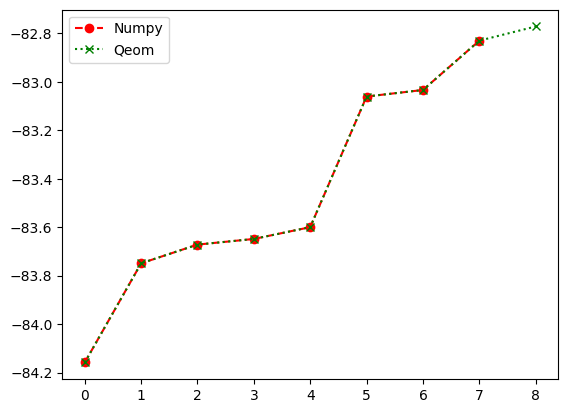

In [ ]:
import matplotlib.pyplot as plt

y = numpy_results.electronic_energies
x = list(range(len(numpy_results.electronic_energies)))
  
plt.plot(x, y, "red", marker='o', linestyle='dashed', animated=True)  

b = qeom_results.electronic_energies
a = list(range(len(qeom_results.electronic_energies)))

plt.plot(a, b, "green", marker='x', linestyle='dotted') 

plt.legend(['Numpy', 'Qeom'])

plt.show()  